# Selenium Scraper for Google Scholar

- gets throttled after about 100 queries
- switch IP addresses with VPN then re-initialize the driver to keep scraping


## Usage

- set paper title to get citation ID
- then run scraper on citation ID
- writes out queries to CSV files

In [242]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.expected_conditions import presence_of_element_located

import time
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

from os.path import join
from PIL import Image
import io
import urllib
from tqdm import tqdm_notebook as tqdm
%reload_ext autoreload
%autoreload 2

from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt

In [268]:
chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(chrome_options=chrome_options)
driver.set_window_size(1920,1600)

/home/adam/anaconda3/envs/megapixels/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: use options instead of chrome_options
  """


In [15]:
url = urllib.parse.unquote('0%2C5')
print(url)

0,5


In [229]:
def gen_citation_url(citation_id, offset, results_per_page=10):
  #htps://scholar.google.com/scholar?cites=6713997626354918066&as_sdt=2005&sciodt=1,5&hl=en
  url_base = 'https://scholar.google.com/scholar?'
  url_params = {
    'start': offset * results_per_page,
    'cites': citation_id,
    'hl': 'en',
    'as_sdt': '2005',
    'sciodt': '1,5'
  }
  url_args = urllib.parse.urlencode(url_params)
  url = url_base +f'{url_args}'
  return url
def gen_url_search(query, offset, results_per_page=10):
  url_base = 'https://scholar.google.com/scholar?'
  url_params = {
    'start': offset*results_per_page,
    'q': query,
    'hl': 'en',
    'as_sdt': '0,5',
  }
  url_args = urllib.parse.urlencode(url_params)
  url = url_base +f'{url_args}'
  return url

In [191]:
def get_citations(driver):
  
  citations = []
  el_citation_container = driver.find_elements_by_id('gs_res_ccl_mid')[0]
  el_citations = el_citation_container.find_elements_by_class_name('gs_scl')

  for el_citation in el_citations:
    
    # get PDF url
    el_pdf_container = el_citation.find_elements_by_class_name('gs_or_ggsm')
    if el_pdf_container:
      el_pdf_container = el_pdf_container[0]
      el_ahref = el_pdf_container.find_elements_by_tag_name('a')[0]
      pdf_url = el_ahref.get_attribute('href')
    else:
      pdf_url = ''

    # get title
    el_title = el_citation.find_elements_by_tag_name('h3')[0]
    title = el_title.text
    
    # get citation ID
    el_title_ahref = el_title.find_elements_by_tag_name('a')
    if el_title_ahref:
      el_title_ahref = el_title_ahref[0]
      citation_id_params = '?' + el_title_ahref.get_attribute('data-clk')
      citation_id_parsed = urllib.parse.urlparse(citation_id_params)
      citation_id = urllib.parse.parse_qs(citation_id_parsed.query)['d'][0]
    else:
      citation_id = ''

    # get description
    el_desc = el_citation.find_elements_by_class_name('gs_rs')
    if el_desc:
      el_desc = el_desc[0]
      desc = el_desc.text
    else:
      desc = ''

    # get authors
    authors = []
    el_authors_outer = el_citation.find_elements_by_class_name('gs_a')
    if el_authors_outer:
      el_authors_outer = el_authors_outer[0]
      el_authors = el_authors_outer.find_elements_by_tag_name('a')
      for el_author in el_authors:
        author = el_author.text
        authors.append(author)
    
    num_citations = 0
    el_footer_outer = el_citation.find_elements_by_class_name('gs_fl')
    if el_footer_outer:
      el_footer_outer = el_footer_outer[-1]
      el_footer_ahrefs = el_footer_outer.find_elements_by_tag_name('a')
      for el_footer_ahref in el_footer_ahrefs:
        if 'cited by' in el_footer_ahref.text.lower():
          num_citations = int(el_footer_ahref.text.lower().replace('cited by', '').strip())
          break

    citation = {
      'gs_title': title,
      'gs_id': citation_id,
      'gs_url': pdf_url,
      'gs_authors': '|'.join(authors),
      'gs_num_citations': num_citations,
      'gs_desc': desc,
    }
                     
    citations.append(citation)
  return citations

In [158]:
import difflib

In [161]:
def similar_score(seq1, seq2):
  return difflib.SequenceMatcher(a=seq1.lower(), b=seq2.lower()).ratio()

In [192]:
#url = gen_url(3)
# search for the title
#title_query = 'Labeled Faces in the Wild: A Survey'
title_query = 'Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments'
url = gen_url_search(title_query, 0)
print(url)

https://scholar.google.com/scholar?start=0&q=Labeled+Faces+in+the+Wild%3A+A+Database+for+Studying+Face+Recognition+in+Unconstrained+Environments&hl=en&as_sdt=0%2C5


In [193]:
driver.get(url)
citations_page = get_citations(driver)

In [194]:
# look for a similar match in the result titles
citation_id = None
num_citations = 0
for c in citations_page:
  gs_title = c['gs_title']
  print('---',gs_title)
  score = similar_score(title_query, gs_title)
  if score > 0.9:
    citation_id = c["gs_id"]
    num_citations = int(c["gs_num_citations"])
    print(f'match: {title_query} is {gs_title}, score: {score}, id: {citation_id}')
    break

--- Labeled faces in the wild: A database forstudying face recognition in unconstrained environments
match: Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments is Labeled faces in the wild: A database forstudying face recognition in unconstrained environments, score: 0.9948186528497409, id: 6713997626354918066


In [183]:
import math

In [195]:
# get all citations for this ID
citations_per_page = 10
num_pages = math.ceil(num_citations / citations_per_page)
print(f'going to scrape {num_pages} pages for {num_citations} citations')

going to scrape 322 pages for 3215 citations


In [273]:
citations = []
pages_skipped = list(range(num_pages))

In [282]:
random.randint(19,29)

27

In [321]:
chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(chrome_options=chrome_options)
w = random.randint(1280,1800)
h = random.randint(720, 2000)
w = 1920
h = 1080
driver.set_window_size(w,h)

/home/adam/anaconda3/envs/megapixels/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: use options instead of chrome_options
  """


In [325]:
import random
def reset_driver():
  global driver
  chrome_options = webdriver.ChromeOptions()
  #chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome(chrome_options=chrome_options)
  w = random.randint(1280,1800)
  h = random.randint(720, 2000)
  w = 1920
  h = 1080
  driver.set_window_size(w,h)

In [326]:
for i in tqdm(range(num_pages), total=num_pages):
  if i not in pages_skipped:
    continue
  try:
    url = gen_citation_url(citation_id, i)
    driver.get(url)
    citations_page = get_citations(driver)
    citations += citations_page
    _ = pages_skipped.pop(pages_skipped.index(i))  # remove from skipped list
  except Exception as e:
    print(f'fail: {e}, i: {i}, url: {url}')
    citations_page = get_citations(driver)
    if i not in pages_skipped:
      pages_skipped.append(i)
    break

In [327]:
print(len(citations))
print(len(pages_skipped), num_pages)

1000
0 322


In [333]:
citations_uniq = []
citation_ids = []
for c in citations:
  citation_id = c['gs_id']
  if citation_id not in citation_ids:
    citation_ids.append(citation_id)
    c['gs_id'] = str(c['gs_id'])
    citations_uniq.append(c)

In [334]:
print(len(citations_uniq))

991


In [330]:
import pandas as pd

In [340]:
df = pd.DataFrame.from_dict(citations_uniq)
df.gs_id = df.gs_id.astype(str)

In [341]:
df.to_csv('/data_store/datasets/people/ijb_c/research/gs_lfw.csv')

In [322]:
# manual
reset_driver()
url = 'https://scholar.google.com/scholar?start=100&hl=en&as_sdt=2005&sciodt=1,5&cites=6713997626354918066&scipsc='
url = 'https://scholar.google.com/scholar?cluster=6713997626354918066&hl=en&as_sdt=2005&sciodt=1,5'
print(url)
driver.get(url)

https://scholar.google.com/scholar?cluster=6713997626354918066&hl=en&as_sdt=2005&sciodt=1,5


In [323]:
el_citation_container = driver.find_elements_by_id('gs_res_ccl_mid')
print(el_citation_container)

[<selenium.webdriver.remote.webelement.WebElement (session="9b02f94f2ede9005c794e501f330abe5", element="0.8440504580108255-1")>]


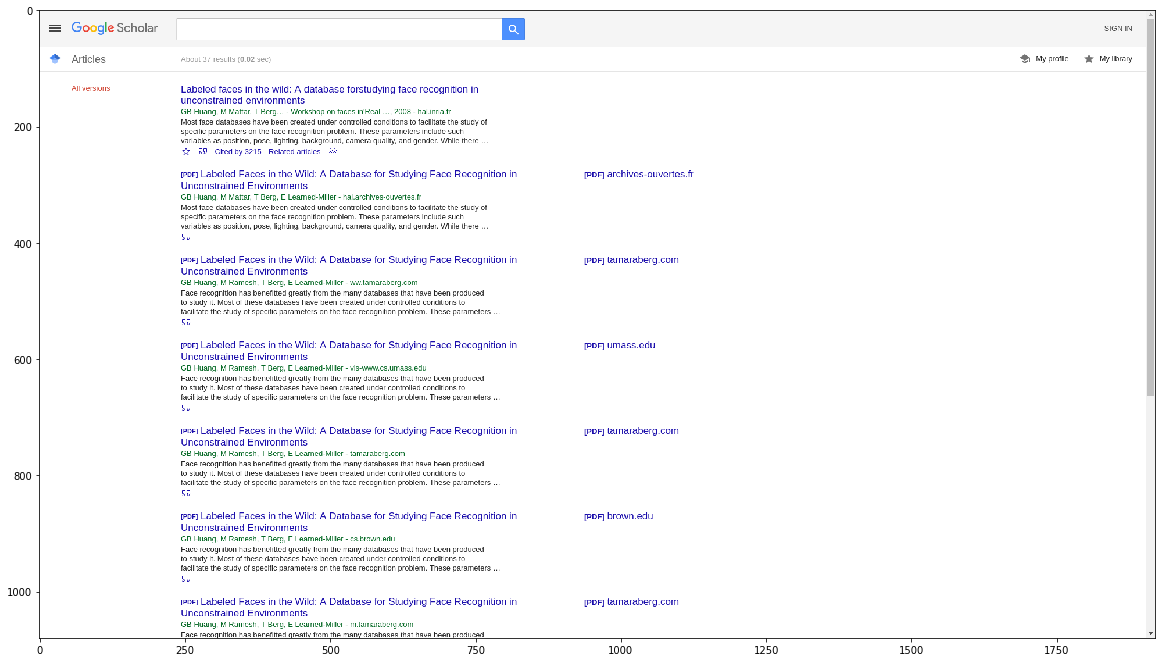

In [324]:
im_bytes = driver.get_screenshot_as_png()
im = Image.open(io.BytesIO(im_bytes))
fig = plt.figure(figsize=(20,14))
plt.imshow(im)
im.save('/home/adam/Downloads/error.png')